In [5]:
import pandas as pd
import numpy as np

# -----------------------------
# 0. 读取数据
# -----------------------------
df = pd.read_excel("Full_data.xlsx").copy()

# -----------------------------
# 1. AHP 工具函数
# -----------------------------
RI_TABLE = { # Saaty 随机一致性指标
    1:0.00, 2:0.00, 3:0.58, 4:0.90, 5:1.12,
    6:1.24, 7:1.32, 8:1.41, 9:1.45, 10:1.49
}

def ahp_weights(A):
    eigvals, eigvecs = np.linalg.eig(A)
    idx = np.argmax(eigvals.real)
    lambda_max = eigvals.real[idx]
    w = eigvecs[:, idx].real
    w = w / w.sum()
    n = A.shape[0]
    CI = (lambda_max - n) / (n - 1) if n > 2 else 0.0
    RI = RI_TABLE.get(n, 1.49)
    CR = CI / RI if RI > 0 else 0.0
    return w, CI, CR, lambda_max

def build_matrix_from_levels(levels, scale_high=5, scale_med=3):
    n = len(levels)
    A = np.ones((n, n), dtype=float)
    for i in range(n):
        for j in range(i+1, n):
            li, lj = levels[i], levels[j]
            if li == lj:
                val = 1.0
            elif li == "H" and lj == "M":
                val = scale_med
            elif li == "M" and lj == "H":
                val = 1.0/scale_med
            elif li == "H" and lj == "L":
                val = scale_high
            elif li == "L" and lj == "H":
                val = 1.0/scale_high
            elif li == "M" and lj == "L":
                val = scale_med
            elif li == "L" and lj == "M":
                val = 1.0/scale_med
            else:
                val = 1.0
            A[i,j] = val
            A[j,i] = 1.0/val
    return A

# -----------------------------
# 2. 定义准则与质量优先等级
# -----------------------------
criteria = [
    "Retention_Rate",
    "Qualifications",
    "Testimonials",           
    "Continuing_Education",
    "Online_Presence",
    "Specializations",
    "Years_Experience",
    "Pricing",
    "Availability"
]

levels = ["H","H","H","M","M","M","M","L","L"]  # 质量优先场景
A_mat = build_matrix_from_levels(levels, scale_high=5, scale_med=3)
weights, CI, CR, lam_max = ahp_weights(A_mat)

print("Quality-first 权重一致性检验：CR = {:.4f}".format(CR))

weights_series = pd.Series(weights, index=criteria, name="Weight")

# -----------------------------
# 3. 特征工程与归一化
# -----------------------------
X = pd.DataFrame(index=df.index)

# Retention_Rate
X['Retention_Rate'] = df['Retention_Rate'].clip(0, 1)

# Qualifications
qual_map = {'ACE':0.8,'NASM':1.0,'ISSA':0.7,'None':0.0}
X['Qualifications'] = df['Qualifications'].map(qual_map).fillna(0.0)

# Testimonials（log压缩防极端）
X['Testimonials'] = np.log1p(df['Testimonials']).astype(float)

# Continuing_Education
X['Continuing_Education'] = df['Continuing_Education'].clip(0,3) / 3.0

# Online_Presence
def presence_count(s):
    if s == 'All': return 3
    if s == 'None': return 0
    return s.count('+') + 1
X['Online_Presence'] = df['Online_Presence'].astype(str).apply(presence_count) / 3.0

# Specializations
X['Specializations'] = df['specialities'].fillna('').astype(str).apply(
    lambda s: 0 if s.strip()=='' else len([t for t in s.split(',') if t.strip()!=''])
)
max_spec = max(1, X['Specializations'].max())
X['Specializations'] = X['Specializations'] / max_spec

# Years_Experience
X['Years_Experience'] = df['years_experience'].fillna(0).clip(0,15) / 15.0

# Pricing（越低越好）
price = df['Pricing'].fillna(df['Pricing'].median())
X['Pricing'] = 1 - (price - price.min())/(price.max() - price.min() + 1e-9)

# Availability（越多越好）
avail = df['Available_Hours_Per_Week'].fillna(0)
X['Availability'] = (avail - avail.min())/(avail.max() - avail.min() + 1e-9)

# 缩放到 [0,1]
for c in X.columns:
    col = X[c].astype(float)
    mn, mx = col.min(), col.max()
    if mx > mn:
        X[c] = (col - mn)/(mx - mn)
    else:
        X[c] = 0.0

# -----------------------------
# 4. 计算综合分
# -----------------------------
df['Final_Score'] = (X[criteria] @ weights_series.values).round(6)

# -----------------------------
# 5. 输出结果
# -----------------------------
with pd.ExcelWriter("New_User.xlsx", engine="openpyxl") as writer:
    df.to_excel(writer, sheet_name="Scored", index=False)
    X.to_excel(writer, sheet_name="Normalized_Features", index=False)
    weights_df = weights_series.reset_index()
    weights_df.columns = ['Criterion', 'Weight']
    weights_df.to_excel(writer, sheet_name="Weights", index=False)

print("✅ Done. 输出文件：New_User.xlsx")


Quality-first 权重一致性检验：CR = 0.0089
✅ Done. 输出文件：New_User.xlsx


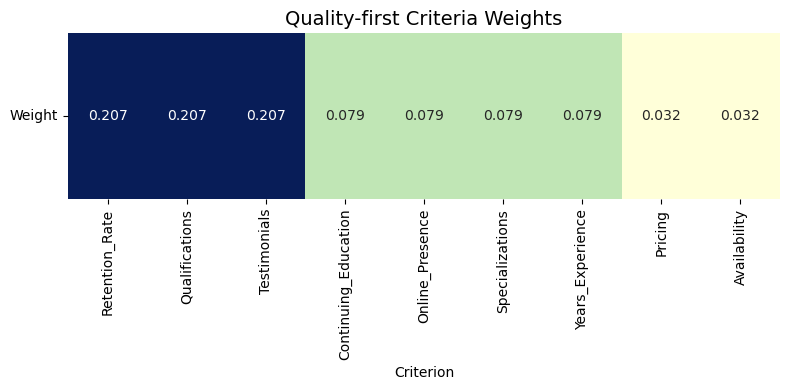

C:\Users\91416\AppData\Local\Temp\ipykernel_18156\2118693037.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


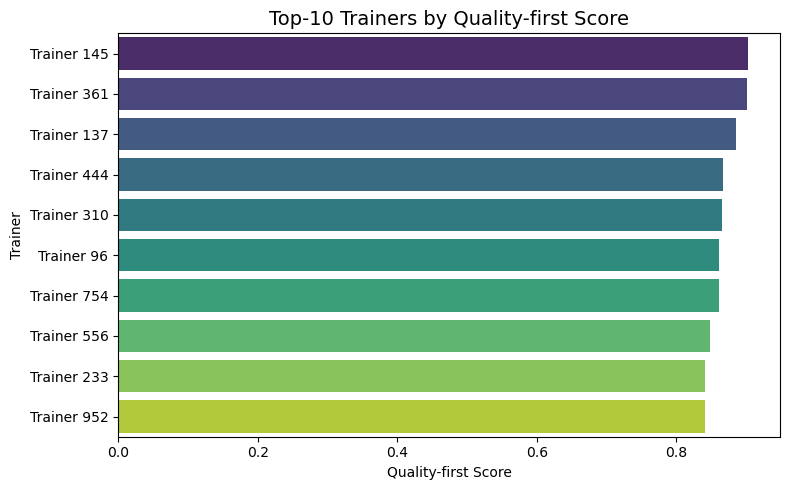

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取结果文件
file_path = "New_User.xlsx"
df = pd.read_excel(file_path, sheet_name="Scored")
weights_df = pd.read_excel(file_path, sheet_name="Weights")

# -----------------------------
# 1. 权重热力图
# -----------------------------
plt.figure(figsize=(8, 4))
weights_df_sorted = weights_df.sort_values("Weight", ascending=False)

sns.heatmap(
    weights_df_sorted.set_index("Criterion").T,
    annot=True, fmt=".3f", cmap="YlGnBu",
    cbar=False
)
plt.title("Quality-first Criteria Weights", fontsize=14)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Top-10 排名条形图
# -----------------------------
top10 = df.sort_values("Final_Score", ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(
    x="Final_Score",
    y="name",
    data=top10,
    palette="viridis"
)
plt.xlabel("Quality-first Score")
plt.ylabel("Trainer")
plt.title("Top-10 Trainers by Quality-first Score", fontsize=14)
plt.tight_layout()
plt.show()
